### IMPORTS

In [1]:
from Inference import BBVI 

In [2]:
import torch
import matplotlib.pyplot as plt
import _pickle as pickle

### EXAMPLE

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [4]:
# load data
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [22]:
Net = BBVI.VariationalNetwork(input_size=1,
                              output_size=1,
                              layer_width=251,
                              nb_layers=2)
Net.set_device(device)

In [23]:
Net.make_deterministic_rhos(Net._sigma_to_rho(torch.tensor(0.001)))
Net.requires_grad_rhos(False)

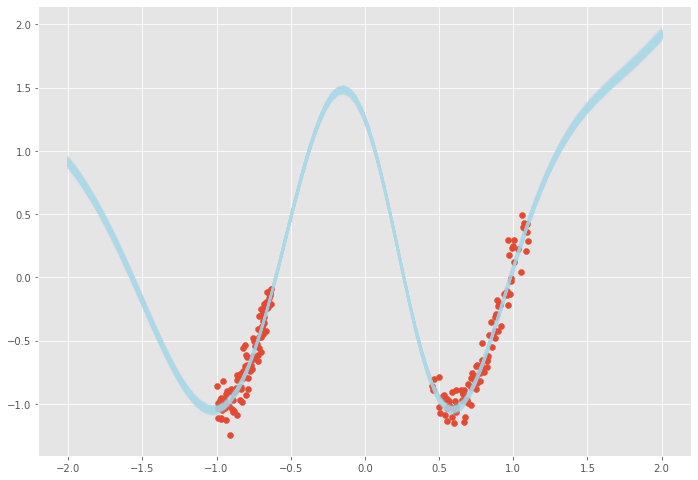

In [26]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue') 

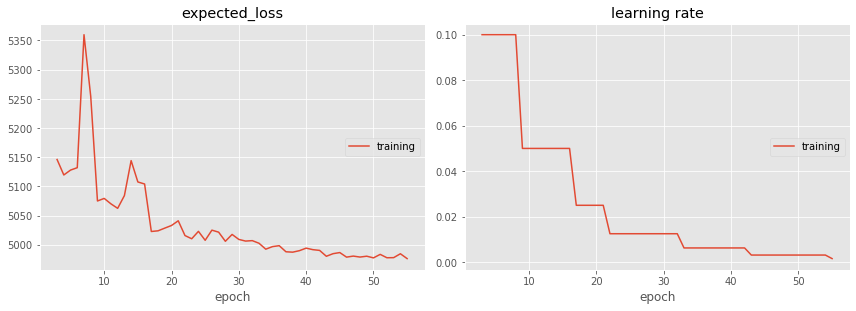

expected_loss:
training   (min: 4976.143, max: 114553.070, cur: 4976.143)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


KeyboardInterrupt: 

In [25]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.1}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 3, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=1000, n_iter=100, n_ELBO_samples=1, plot=True)

In [27]:
Net.requires_grad_mus(False)
Net.requires_grad_rhos(True)

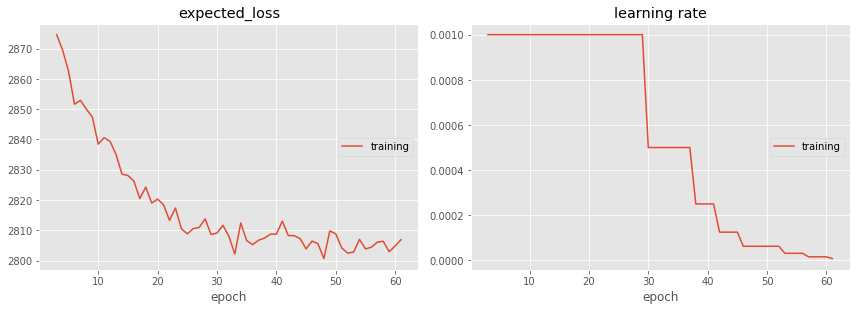

expected_loss:
training   (min: 2800.635, max: 2891.106, cur: 2806.903)

learning rate:
training   (min:    0.000, max:    0.001, cur:    0.000)


In [30]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.001}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 3, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=100, n_iter=100, n_ELBO_samples=100, plot=True)

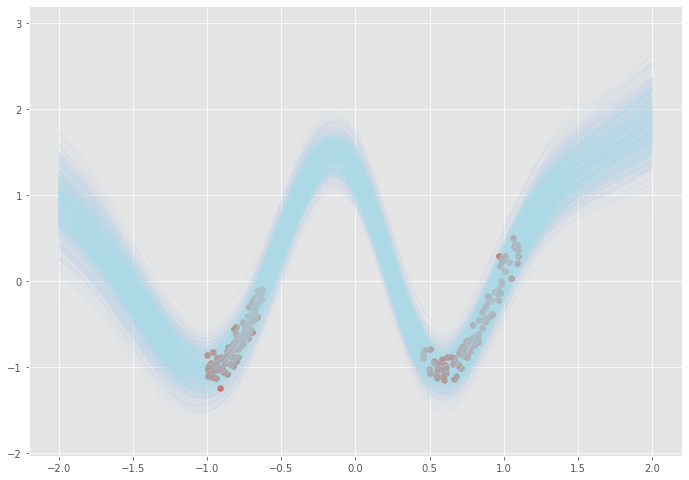

In [31]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [21]:
torch.cat([torch.cat((torch.flatten(self.registered_layers[k].q_weight_mu), self.registered_layers[k].q_bias_mu)) for k in range(len(self.registered_layers))]).shape

torch.Size([754])

In [15]:
n_samples_ELBO = 111

In [20]:
self = Net

In [17]:
(layered_w_samples, layered_bias_samples) = self.sample_parameters(n_samples_ELBO)

LQ = self.q_log_pdf(layered_w_samples, layered_bias_samples)
LP = self.prior_log_pdf(layered_w_samples, layered_bias_samples)
MCKL = (LQ - LP).mean()

y_pred = self.forward(x_data)
mu = torch.flatten(y_pred, end_dim=1)
sigma = torch.eye(y_data.shape[1],device=device)*torch.tensor(0.1, device=device)
nd = torch.distributions.MultivariateNormal(mu, scale_tril=sigma)
LL = nd.log_prob(torch.flatten(y_data.repeat(y_pred.shape[0], 1, 1), end_dim=1))
eLL = LL.reshape(y_pred.shape[0:2]).sum(1).mean()

loss = MCKL - eLL